### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math 

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

b_values = sample_truncated_normal(mean=1/np.sqrt(2), std=0.05, size=math.ceil(n_test*(2/3)))

# Clase 1: rho1, etiqueta = 1
a_test = np.random.uniform(0, 1, int(n_test//3))
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

for b in b_values:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 50
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

b_values = sample_truncated_normal(mean=1/np.sqrt(2), std=0.05, size=math.ceil(n_samples*(2/3)))

a_values = np.random.uniform(0, 1, int(n_samples//3))
for a in a_values:
    rho, label = ρ1(a)  # rho es matriz 4x4, label = 1
    data.append((rho, label))

for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

# Mezclar y dividir: 80% entrenamiento, 20% validación
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 35  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   1%|          | 50/5000 [01:22<3:06:09,  2.26s/it]

Iter  50: train_loss=11.2436, val_loss=16.1390, train_suc=0.352, train_err=0.328, train_inc=0.320 | val_suc=0.229, val_err=0.419, val_inc=0.352


Entrenando:   2%|▏         | 100/5000 [03:20<3:10:11,  2.33s/it]

Iter 100: train_loss=8.1681, val_loss=11.0321, train_suc=0.429, train_err=0.228, train_inc=0.342 | val_suc=0.341, val_err=0.274, val_inc=0.385
Iter 100: LR actual = 0.010000


Entrenando:   3%|▎         | 150/5000 [05:39<3:29:46,  2.60s/it]

Iter 150: train_loss=5.4500, val_loss=6.3292, train_suc=0.572, train_err=0.143, train_inc=0.286 | val_suc=0.487, val_err=0.145, val_inc=0.367


Entrenando:   4%|▍         | 200/5000 [08:16<3:56:52,  2.96s/it]

Iter 200: train_loss=3.2753, val_loss=4.4966, train_suc=0.599, train_err=0.105, train_inc=0.296 | val_suc=0.519, val_err=0.092, val_inc=0.389
Iter 200: LR actual = 0.010000


Entrenando:   5%|▌         | 250/5000 [10:48<5:31:07,  4.18s/it]

Iter 250: train_loss=4.1121, val_loss=3.5311, train_suc=0.596, train_err=0.096, train_inc=0.308 | val_suc=0.531, val_err=0.064, val_inc=0.405


Entrenando:   6%|▌         | 300/5000 [13:04<3:32:31,  2.71s/it]

Iter 300: train_loss=4.7575, val_loss=3.8867, train_suc=0.605, train_err=0.093, train_inc=0.302 | val_suc=0.528, val_err=0.075, val_inc=0.397
Iter 300: LR actual = 0.010000


Entrenando:   7%|▋         | 350/5000 [15:44<5:44:16,  4.44s/it]

Iter 350: train_loss=1.6448, val_loss=3.5599, train_suc=0.600, train_err=0.093, train_inc=0.307 | val_suc=0.531, val_err=0.065, val_inc=0.404


Entrenando:   8%|▊         | 400/5000 [19:55<6:27:18,  5.05s/it]

Iter 400: train_loss=4.8294, val_loss=3.6172, train_suc=0.601, train_err=0.093, train_inc=0.306 | val_suc=0.530, val_err=0.067, val_inc=0.403
Iter 400: LR actual = 0.010000


Entrenando:   9%|▉         | 450/5000 [23:45<5:58:49,  4.73s/it]

Iter 450: train_loss=5.9219, val_loss=3.7319, train_suc=0.603, train_err=0.092, train_inc=0.304 | val_suc=0.529, val_err=0.070, val_inc=0.400


Entrenando:  10%|█         | 500/5000 [27:46<6:16:48,  5.02s/it]

Iter 500: train_loss=5.6211, val_loss=3.6594, train_suc=0.602, train_err=0.092, train_inc=0.305 | val_suc=0.530, val_err=0.068, val_inc=0.402
Iter 500: LR actual = 0.010000


Entrenando:  11%|█         | 550/5000 [31:38<5:57:00,  4.81s/it]

Iter 550: train_loss=2.7617, val_loss=3.7961, train_suc=0.604, train_err=0.093, train_inc=0.303 | val_suc=0.529, val_err=0.072, val_inc=0.399


Entrenando:  12%|█▏        | 600/5000 [35:22<6:03:44,  4.96s/it]

Iter 600: train_loss=3.2050, val_loss=4.1417, train_suc=0.607, train_err=0.095, train_inc=0.298 | val_suc=0.525, val_err=0.082, val_inc=0.393
Iter 600: LR actual = 0.010000


Entrenando:  13%|█▎        | 630/5000 [37:55<6:13:26,  5.13s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  13%|█▎        | 650/5000 [39:31<6:33:48,  5.43s/it]

Iter 650: train_loss=2.0820, val_loss=3.7466, train_suc=0.603, train_err=0.093, train_inc=0.304 | val_suc=0.529, val_err=0.071, val_inc=0.400


Entrenando:  14%|█▍        | 700/5000 [43:15<5:49:17,  4.87s/it]

Iter 700: train_loss=6.6752, val_loss=3.7057, train_suc=0.603, train_err=0.092, train_inc=0.305 | val_suc=0.530, val_err=0.070, val_inc=0.401
Iter 700: LR actual = 0.005000


Entrenando:  15%|█▌        | 750/5000 [47:24<5:46:13,  4.89s/it]

Iter 750: train_loss=5.8844, val_loss=3.6533, train_suc=0.602, train_err=0.092, train_inc=0.305 | val_suc=0.530, val_err=0.068, val_inc=0.402


Entrenando:  16%|█▌        | 780/5000 [49:48<5:42:42,  4.87s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  16%|█▌        | 800/5000 [51:33<7:07:07,  6.10s/it]

Iter 800: train_loss=3.4638, val_loss=3.6958, train_suc=0.603, train_err=0.092, train_inc=0.305 | val_suc=0.530, val_err=0.069, val_inc=0.401
Iter 800: LR actual = 0.002500


Entrenando:  17%|█▋        | 850/5000 [55:46<5:26:18,  4.72s/it]

Iter 850: train_loss=2.9315, val_loss=3.6684, train_suc=0.602, train_err=0.092, train_inc=0.305 | val_suc=0.530, val_err=0.068, val_inc=0.402


Entrenando:  18%|█▊        | 900/5000 [59:27<5:07:54,  4.51s/it]

Iter 900: train_loss=5.0988, val_loss=3.6247, train_suc=0.602, train_err=0.093, train_inc=0.306 | val_suc=0.530, val_err=0.067, val_inc=0.403
Iter 900: LR actual = 0.002500


Entrenando:  19%|█▊        | 930/5000 [1:01:45<4:59:12,  4.41s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  19%|█▉        | 950/5000 [1:03:18<4:47:25,  4.26s/it]

Iter 950: train_loss=3.1590, val_loss=3.7761, train_suc=0.604, train_err=0.093, train_inc=0.304 | val_suc=0.529, val_err=0.072, val_inc=0.399


Entrenando:  20%|█▉        | 980/5000 [1:05:24<4:28:18,  4.00s/it]

Early stopping en iteración 981. Mejor pérdida de validación: 3.469967

Parámetros entrenados:
[3.46204961 4.71238546 4.757887   0.44808771 4.71238898 3.14159265
 4.19761224 4.83410717 2.93140587 0.33339336 6.28318531 5.193312
 5.55864433 3.25688519 0.84348762 4.02717557 4.20257697 4.87414562
 4.66689096 4.71238655 0.31448321 0.13822057 1.89367897 1.19614823
 3.44998041 6.2179192  4.31964542 4.757887   4.71238321 3.55241592]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.5767
  Error promedio     = 0.0955
  Inconcluso promedio = 0.3278


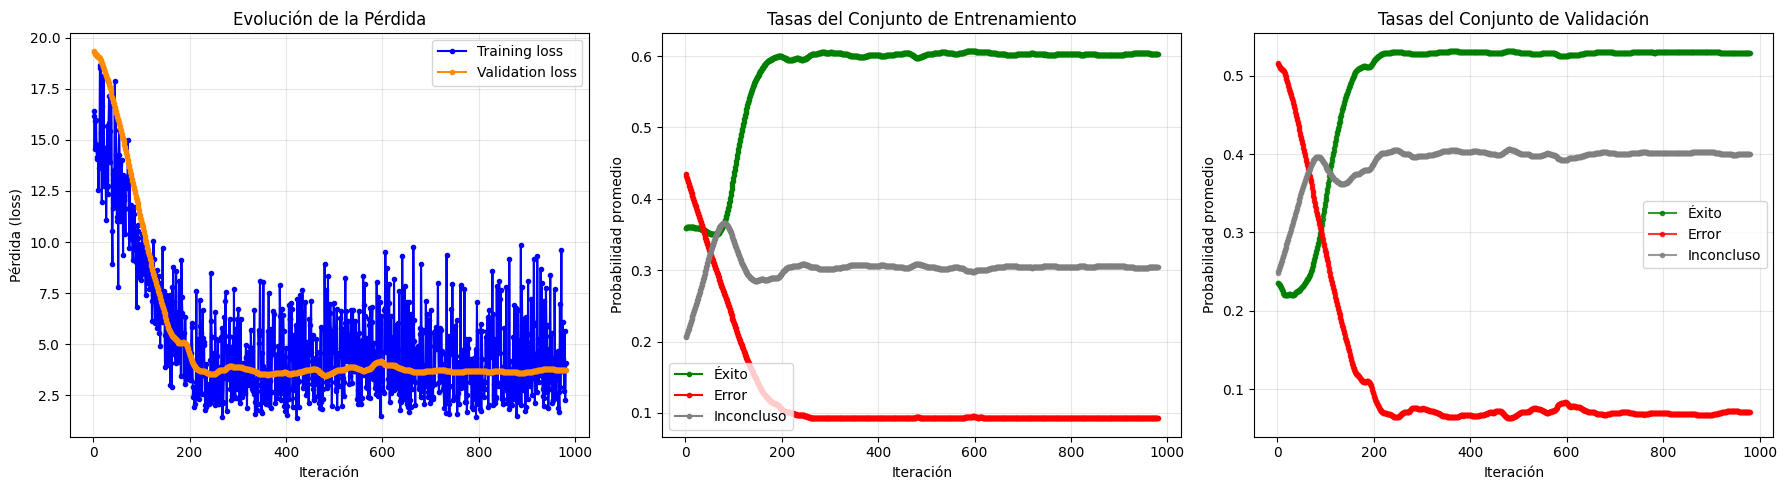

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

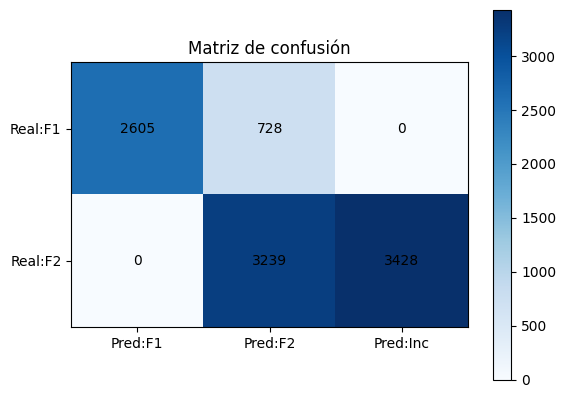

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
